In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T152207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a91bdd7a2f406f4b4d9e7553083c1c7d4d7784f0a5fb6ca3a3453c2467da1be6f5b608dd093fbe883f6db835d404724ccac90be6c1802d5f1dd6017c1af6f324f1c05eac26adbff99a5a558bba7a002c106982a634a467cd1c2d072e017077ea8af8af5ea1e7567371aa1517846dda3b7ca9f573ef4e1fd3a6cfff525d2b1a489d5ab8d83ecbc487fc062c52c83d7a65e332710a6859b1d0699358d5b99f363059ff6b96f2cfb17c8c8224286eec41cb41bf28be0a545f743ed3e2e8c6ec4d9634c5c1a65a48cb0644408357b9d085c1bcacc042b25a2b746dbefa5d35d54fb4a4f84267d44c3995e09d2e8fc37bdd5d423cb174b6c523aa7aa92d78df59d1d,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T152207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8611944aaf55aa671190ad96ec595ac0552a6fa22b3217c8abcdbb409b7ea1049c3aaba38f9c3c49baf87ce96c77619acf002c49d125ee42fe3d3fdd06012209eb230e975079aab3e55f8c34fecfcf0010434412848119c19bb00567f3bd0bbc8168af12b543135373248fe8b686a837be08b5585089c6d79d65537202697c22d9a6fb9227347988e418b4780cd68079e45531b66f0eff73771a7c70b50ecd16a7edac61d831695b029bbc81a4d974309b9997af1fec6ab9c97050d09981f6d7308c5c61d75d4969f6ffae8f3f8d0840e6dde19771f4067b1df69577be30db5a8ae9901773567ad28cb55c51078c1ad3b6738ea227648e4617d16cd1a8db57aa,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T152207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25172e20ae286ab5ccbd60e2ee6f6958d755f89389d20bc82b7c699a1c58c274f888a71718f40e6a8166849f36c75bc4b024c8dcc36d838b82bfc0972b925c2804d3899c396e4cb3d3d6f50851b11c17b60e46524478123cc6322be468d31616ace959ec40de823d5917fd877c024875755d937dff446e2cc0174f200d79eaec5aa67795c0102c508ede776cab25ccc4bc94b4d0a22c8124ccb10200c8e55ca472ea8edddfd50796e62718ad11bf4cd887e9b1cfbf1d075be825bb19951bb0895a6496b59e6a145fcb4abdf7ac96bc99f327532af9d2518f4d920a8ec839871906d74a10f673c936a1d7c1341f4dda66e34b87309329c7e20c31c1f1f6f6552b,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T152207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2947fef486abd0150cdb3d9ebae7046364ee0ef29cbe5f46dd5faeb3f407d6228f3636a777742cdffe40184fe0d9f2e94e31d7727b607ae3350151cd3a66842cd1fed74a7c22e3192d5b611e3d21b8992ad6586d0bd9bb23578b3519d90e9238a024fba60bfca44c81d3fa816e08b869a749c4f0c26f73f7df7afbf993d622918d6f9c99082857dc3c1c67d62b0fa1fcf3265e2cba0eb9dde4765c3df73929c2668888df2022a926323f43d3421dbddb1b4cb6b2008a285a83e9b64bc99b486a8674e10654c3896ec654c24aa0138dc9e72f284d073b40d5a1c4873253ae71c3b5f5512f749900eefbc8405b81927dc2becbbb62c1d90635fe99084aba27712d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
Data source import complete.


# Importing Libraries

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import warnings

# Ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    happy  /kaggle/input/ravdess-emotional-speech-audio/a...
1  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
2     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
3  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4      sad  /kaggle/input/ravdess-emotional-speech-audio/a...

## <center>2. Crema DataFrame</center>

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /kaggle/input/cremad/AudioWAV/1027_ITH_ANG_XX.wav
1  disgust  /kaggle/input/cremad/AudioWAV/1069_TSI_DIS_XX.wav
2  neutral  /kaggle/input/cremad/AudioWAV/1011_WSI_NEU_XX.wav
3      sad  /kaggle/input/cremad/AudioWAV/1049_ITS_SAD_XX.wav
4  neutral  /kaggle/input/cremad/AudioWAV/1004_MTI_NEU_XX.wav

##  <center> 3. TESS dataset <center>

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
1  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
2  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
3  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
4  surprise  /kaggle/input/toronto-emotional-speech-set-tes...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  /kaggle/input/surrey-audiovisual-expressed-emo...
1    angry  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
4  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    happy  /kaggle/input/ravdess-emotional-speech-audio/a...
1  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
2     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
3  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4      sad  /kaggle/input/ravdess-emotional-speech-audio/a...

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Path'].value_counts()
    for x_label, grp in _df_2.groupby('Emotions')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Emotions')
_ = plt.ylabel('Path')

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

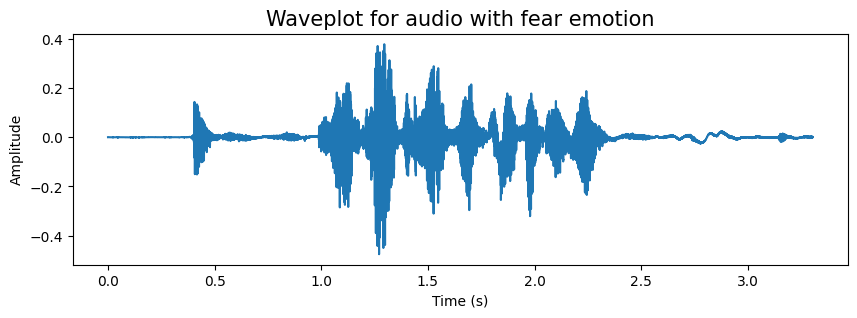

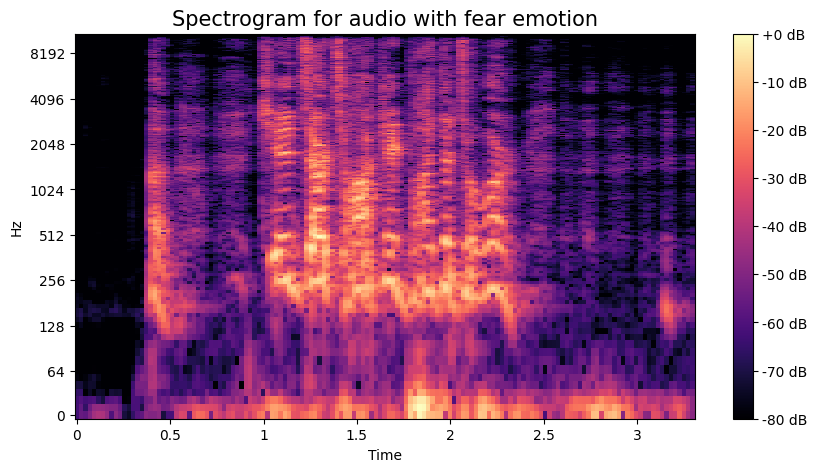

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define the updated create_waveplot function
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    plt.plot(np.linspace(0, len(data) / sr, num=len(data)), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Define the create_spectrogram function
def create_spectrogram(data, sr, emotion):
    plt.figure(figsize=(10, 5))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Set the emotion and path
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


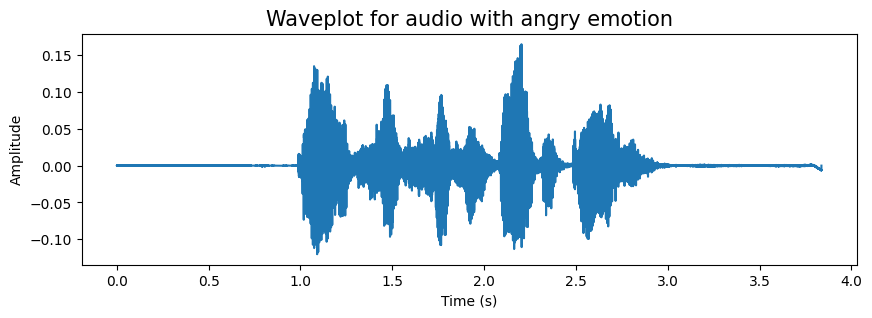

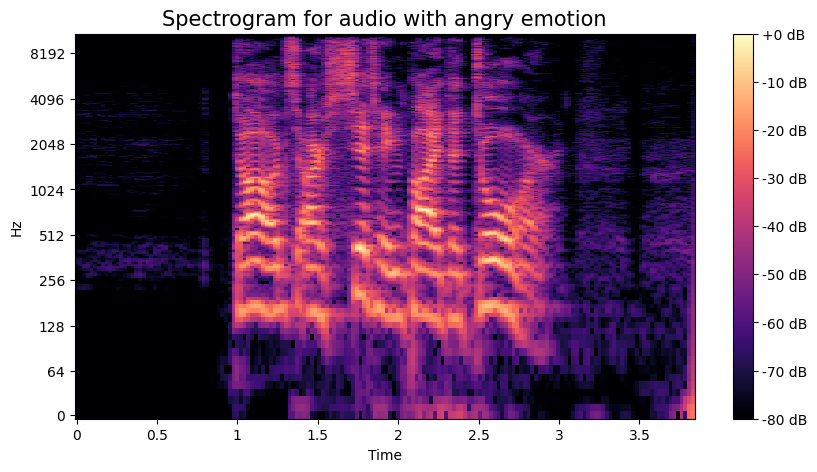

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


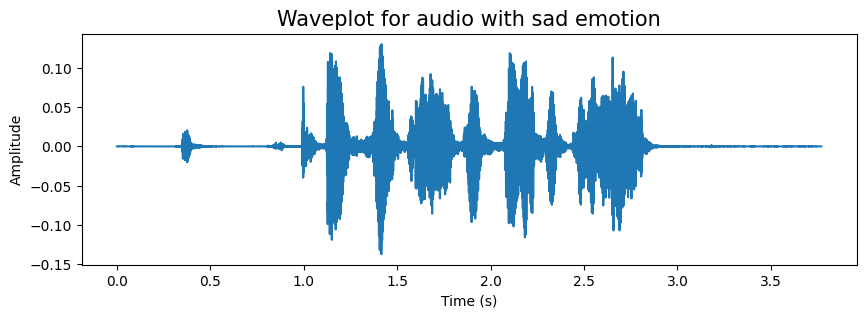

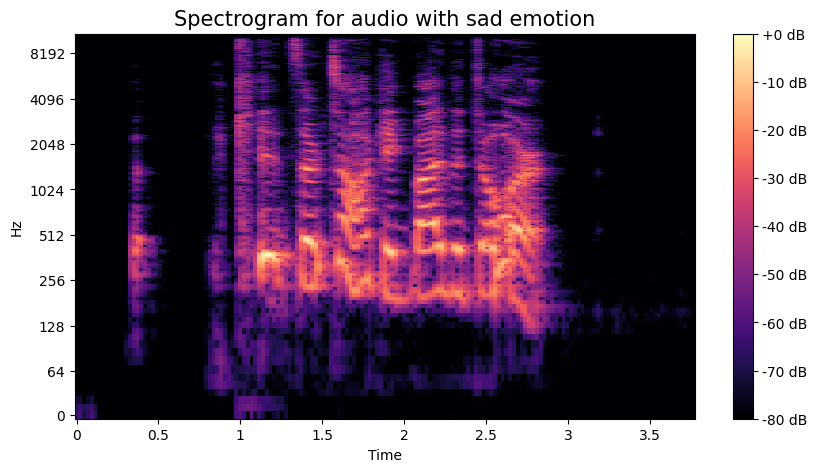

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


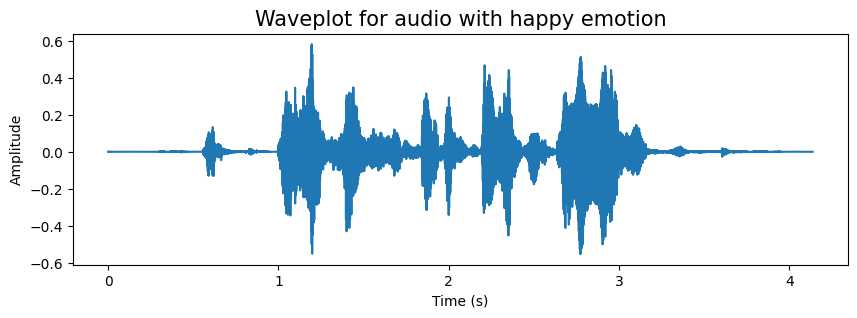

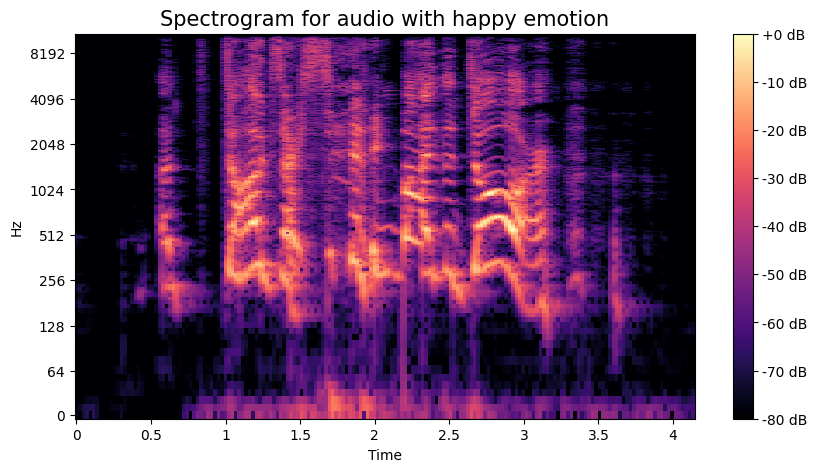

In [ ]:
emotion='happy'

path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio file
Audio(path)


## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

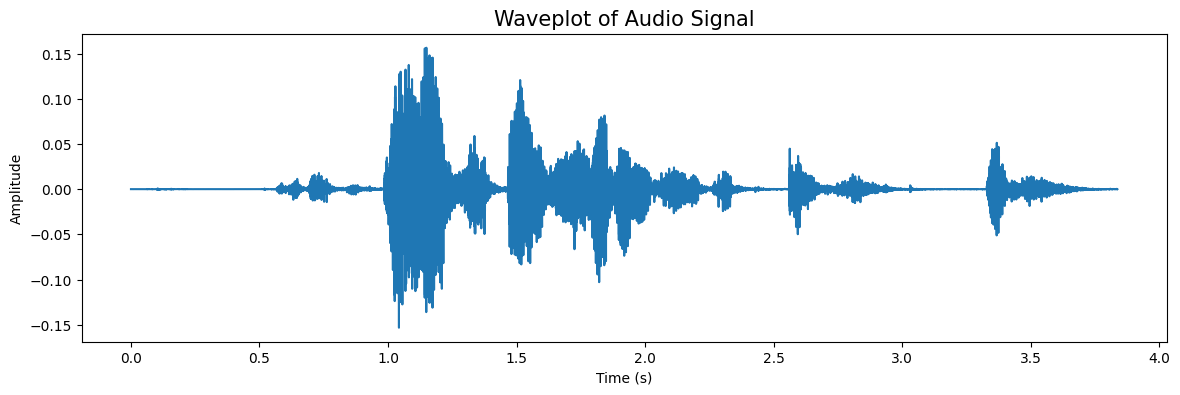

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define a function to create a waveform plot
def create_waveplot(data, sr):
    plt.figure(figsize=(14, 4))
    plt.title('Waveplot of Audio Signal', size=15)
    plt.plot(np.linspace(0, len(data) / sr, num=len(data)), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Create and display the waveform plot
create_waveplot(data, sampling_rate)

# Play the audio file
Audio(path)


#### 2. Noise Injection

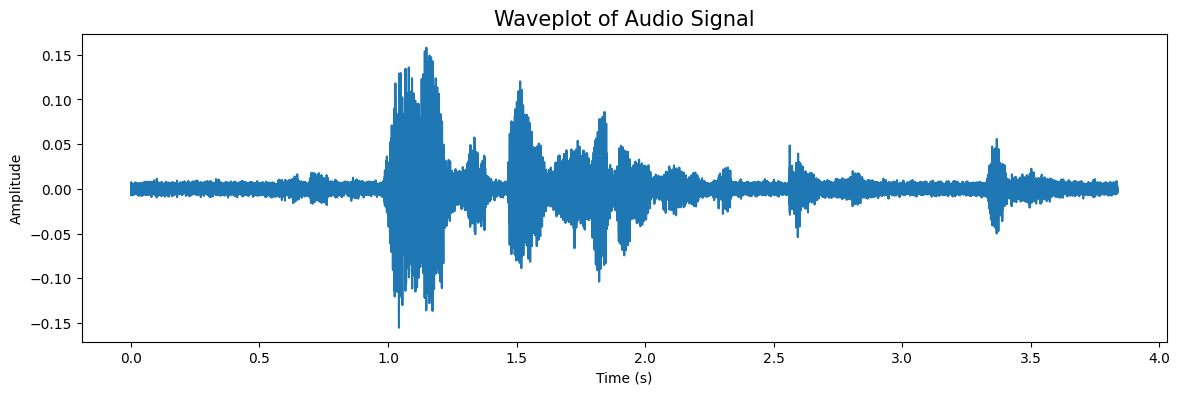

In [ ]:
x = noise(data)

# Create and display the waveform plot
create_waveplot(x, sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

In [ ]:
!pip install librosa==0.9.2

In [ ]:
import librosa

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate)

x = stretch(data)
# Create and display the waveform plot
create_waveplot(x, sample_rate)
Audio(x, rate=sample_rate)


<ipython-input-19-82dc94345890>:4: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data,rate)


In [ ]:
import librosa
print(librosa.__version__)


0.9.2


#### 4. Shifting

In [ ]:
x = shift(data)


#### 5. Pitch

In [ ]:
x = pitch(data, sample_rate)


<ipython-input-16-5b9b6760674a>:14: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

<ipython-input-19-82dc94345890>:4: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data,rate)
<ipython-input-16-5b9b6760674a>:14: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
<ipython-input-16-5b9b6760674a>:14: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
<ipython-input-19-82dc94345890>:4: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data,rate)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Tr

In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

Features.head()

0         1         2         3         4         5         6  \
0  0.151042  0.609451  0.607373  0.546294  0.536419  0.477248  0.453658   
1  0.222896  0.688033  0.668672  0.603628  0.611956  0.557105  0.483008   
2  0.156442  0.662466  0.642071  0.580518  0.485431  0.479580  0.429996   
3  0.141814  0.625484  0.646640  0.675011  0.659553  0.634999  0.603683   
4  0.277787  0.714762  0.760339  0.786280  0.775842  0.751805  0.659593   

          7         8         9  ...       153       154       155       156  \
0  0.524962  0.561725  0.515346  ...  0.004712  0.004819  0.005618  0.006241   
1  0.540593  0.589119  0.550086  ...  0.006843  0.007322  0.008047  0.008390   
2  0.452157  0.512514  0.504649  ...  0.000804  0.000983  0.001333  0.000956   
3  0.592915  0.628504  0.634250  ...  0.002234  0.001598  0.002061  0.002148   
4  0.650655  0.701524  0.692538  ...  0.002465  0.001810  0.002297  0.002351   

        157       158       159       160           161   labels  
0  0.006411  0.004220  0.001178  0.000089  1.168559e-06    happy  
1  0.008745  0.006486  0.003323  0.002303  2.217523e-03    happy  
2  0.000996  0.000859  0.000253  0.000014  9.358641e-08    happy  
3  0.002384  0.002222  0.000741  0.000048  6.613298e-07  disgust  
4  0.002613  0.002426  0.000967  0.000271  2.239572e-04  disgust  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 209s 484ms/step - loss: 1.7267 - accuracy: 0.2962 - val_loss: 1.5220 - val_accuracy: 0.3868 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 209s 488ms/step - loss: 1.5000 - accuracy: 0.3975 - val_loss: 1.3949 - val_accuracy: 0.4442 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 202s 471ms/step - loss: 1.4081 - accuracy: 0.4379 - val_loss: 1.2968 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 200s 467ms/step - loss: 1.3394 - accuracy: 0.4670 - val_loss: 1.2358 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 207s 482ms/step - loss: 1.2964 - accuracy: 0.4833 - val_loss: 1.1975 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 201s 471ms/step - loss: 1.2606 - accuracy: 0.4996 - val_loss: 1.2035 - val_accuracy: 0.5194 - lr: 0.0010
Epoch 7/50
428/428 [==========================

In [ ]:
model.save('emotion_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 20s 69ms/step - loss: 1.1356 - accuracy: 0.6048
Accuracy of our model on test data :  60.480159521102905 %


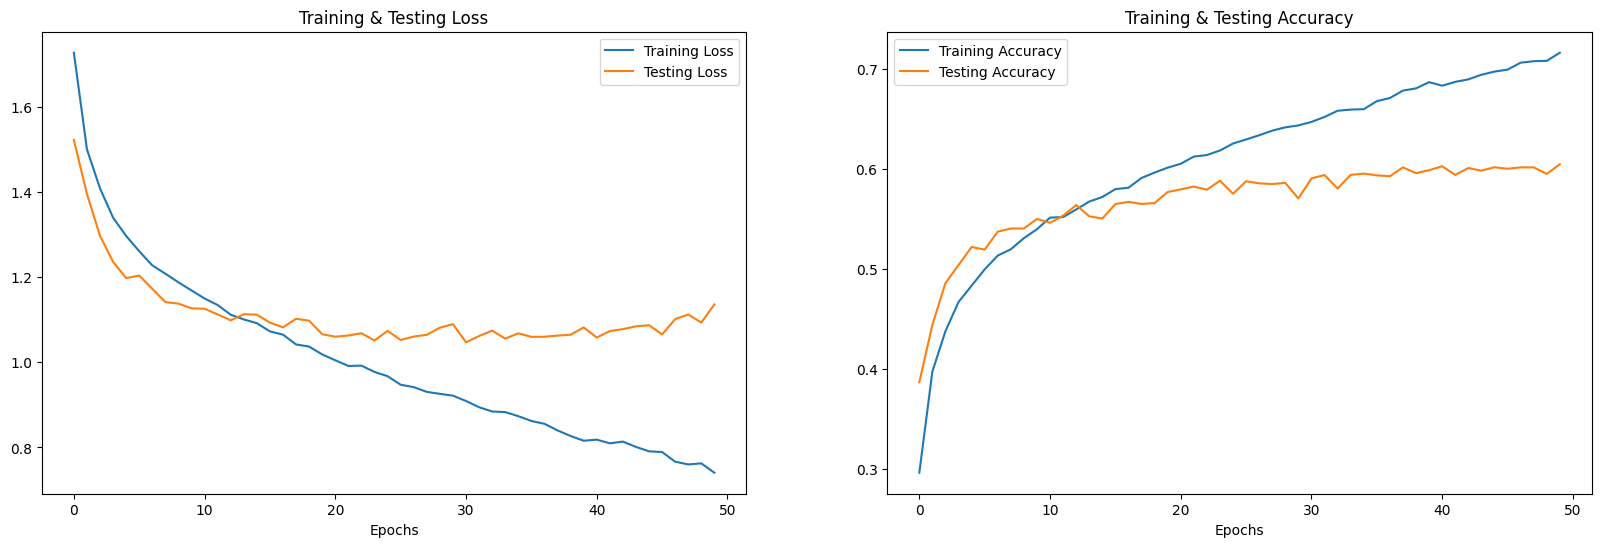

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 17s 59ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1          disgust       disgust
2         surprise      surprise
3            happy       disgust
4          neutral       disgust
5              sad       disgust
6             calm           sad
7             fear          fear
8          neutral       neutral
9            angry         angry

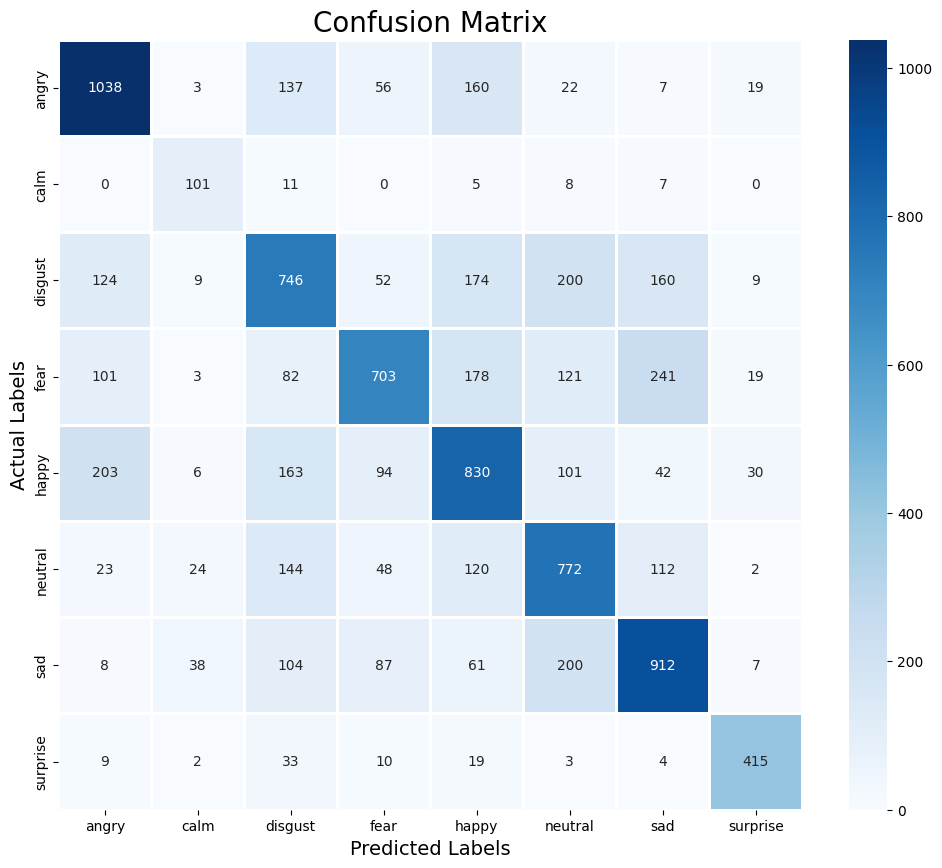

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.69      0.72      0.70      1442
        calm       0.54      0.77      0.64       132
     disgust       0.53      0.51      0.52      1474
        fear       0.67      0.49      0.56      1448
       happy       0.54      0.57      0.55      1469
     neutral       0.54      0.62      0.58      1245
         sad       0.61      0.64      0.63      1417
    surprise       0.83      0.84      0.83       495

    accuracy                           0.60      9122
   macro avg       0.62      0.64      0.63      9122
weighted avg       0.61      0.60      0.60      9122



In [ ]:
import librosa
import numpy as np

# Load the audio file
def load_audio_file(file_path):
    data, sample_rate = librosa.load(file_path, sr=None)
    return data, sample_rate


In [ ]:
import joblib

# Assuming you have trained your model and processed your data as shown previously

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the encoder
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

# Flatten the 3D data to 2D for fitting the scaler
x_train_2d = np.squeeze(x_train, axis=2)
x_test_2d = np.squeeze(x_test, axis=2)

# Fit the scaler on the 2D training data
scaler = StandardScaler()
scaler.fit(x_train_2d)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Fit the encoder on the labels
encoder = OneHotEncoder()
encoder.fit(np.array(Features['labels']).reshape(-1, 1))

# Save the encoder
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

In [ ]:
import numpy as np
import librosa
from keras.models import load_model
import joblib

def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # Data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))

    return result

def predict_emotion(path):
    # Load the saved model
    model = load_model('/content/emotion_model.h5')

    # Load the scaler and encoder used for training
    scaler = joblib.load('/content/scaler.pkl')
    encoder = joblib.load('/content/encoder.pkl')

    # Extract features from the audio file
    features = get_features(path)

    # Scale the features
    features_scaled = scaler.transform(features)

    # Reshape for the model
    features_reshaped = np.expand_dims(features_scaled, axis=2)

    # Predict
    predictions = model.predict(features_reshaped)

    # Average the predictions
    prediction_mean = np.mean(predictions, axis=0)

    # Decode the one-hot encoded prediction
    predicted_emotion = encoder.inverse_transform([prediction_mean])

    return predicted_emotion[0]

# Test the model with a new MP3 file
file_path = '/content/what-104696.mp3'
predicted_emotion = predict_emotion(file_path)

# Print the predicted emotion
print(f'Predicted Emotion: {predicted_emotion}')


1/1 [==============================] - 0s 237ms/step
Predicted Emotion: ['neutral']
